# Analítica de datos
# Examen parcial 1
# 2020-01
# <font color='red'> Steven Bernal, A00021016 </font>

El dataset que deben analizar contiene los registros del histórico de las personas a las que se les ha otorgado un crédito financiero, indicando quienes pudieron pagarlo sin problemas y quienes no.

La idea es poder predecir, utilizando modelos de aprendizaje supervisado (KNN y Naïve Bayes) y las variables independientes disponibles qué aspirantes a un crédito tienen mas o menos riesgo de pagar.

Las variables de la hoja de datos son las siguientes:
- ID: El ID único del cliente en el banco. Variable numérica positiva. 
- PudoPagar: Indica si el cliente ha podido pagar el crédito sin problemas (1) o no (0). Variable categórica binaria.
- Estudiante: Indica si el cliente es estudiante (Si) o no lo es (No). Variable categórica binaria.
- Deuda: Indica la cantidad de dinero que aún adeuda el cliente correspondiente a préstamos. Valores numéricos positivos o en cero.
- Cuenta: Indica el dinero que tiene en la cuenta del banco. Valores numéricos. Estas cuentas no permiten tener saldo en rojo.

## Entendimiento de los datos, limpieza

El archivo "creditos_examen.csv" contiene el dataset que tienen que analizar.
Se recomienda abrirlo primero en un lector de archivos planos para entender preliminarmente su formato y así poderlo cargar adecuadamente con Python.

Teniendo en cuenta el tipo de problema en cuestión (clasificación o regresión), realice un análisis exploratorio de los datos estableciendo el baseline, verificando la calidad de los datos (tipos de las variables, valores inválidos, excepciones, valores faltantes, etc.), utilizando gráficos para poder entender las distribuciones de los datos e identificar posibles problemas.

#### Puntos a desarrollar

- <font color='red'>1. Limpieza de datos: Exploren los datos e identifiquen problemas e inconsistencias del dataset teniendo en cuenta el diccionario de datos y del contexto. Arreglen los problemas identificados (solo después de identificarlos todos), argumentando sus decisiones. (2.0)</font>
- <font color='red'>2. Obtengan el modelo de referencia (Baseline), interprételo y calcule su accuracy. (0.3)</font>

## Modelamiento con K-NN y Naïve Bayes

#### Puntos a desarrollar:

<font color='red'>Entrene modelos de clasificación siguiendo el siguiente protocolo:</font>
- <font color='red'>3. Haga un holdout estratificado 70% training - 30% test sobre el dataset solo incluyendo las variables numéricas. No olvide normalizar los datos correctamente (0.3)</font>
- <font color='red'>4. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo K-NN, teniendo en cuenta el Kappa. Evaluar un modelo global, otro para estudiantes y otro para no estudiantes. Concluir (0.9)</font>
- <font color='red'>5. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo NaïveBayes, tenga en cuenta utilizar las distribuciones adecuadas a los tipos de variables predictivas. Repetir el proceso de los tres modelos. (0.9) Si quisieramos incluir el efecto de la variable Estudiante en el modelo entrenado con las variables numéricas sin utilizar sklearn, que tenemos que hacer (0.2)</font>
- <font color='red'>6. Sobre el test set compare los dos modelos (K-NN y NB) y escoja el mejor según el Kappa (0.4)</font>

# Desarrollo de los puntos

In [451]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics

In [452]:
%matplotlib inline

# Exploración de datos

In [453]:
dStud = pd.read_csv('creditos_examen.csv', sep=";")
dStud.tail()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
9997,9996,0,No,5299238,3557775
9998,9997,0,No,1966072,3789815
9999,9998,0,No,5863616,4227060
10000,9999,0,No,3666911,7845045
10001,10000,0,Si,1686295,1004611


In [454]:
dStud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 5 columns):
ID            10002 non-null int64
PudoPagar     10002 non-null int64
Estudiante    9998 non-null object
Deuda         10002 non-null int64
Cuenta        10002 non-null int64
dtypes: int64(4), object(1)
memory usage: 390.8+ KB


In [455]:
dStud.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,10002.000000,10002.000000,9998,1.000200e+04,1.000200e+04
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,7050,NaN,NaN
mean,5000.379324,0.033293,NaN,3.036624e+06,1.545269e+07
std,2887.127481,0.179410,NaN,7.028235e+07,1.019546e+09
min,-3.000000,0.000000,NaN,-4.288864e+09,-2.247063e+07
25%,2500.250000,0.000000,NaN,1.823657e+06,2.408188e+06
50%,5000.500000,0.000000,NaN,3.209805e+06,4.118185e+06
75%,7500.750000,0.000000,NaN,4.281461e+06,5.833152e+06


## Identificación Problemas

### Primer Problema (Variable categorica con un tipo entero)

In [456]:
dStud['PudoPagar'].dtype

dtype('int64')

### Segundo Problema (Variable categorica binaria con mas de dos valores)

In [457]:
dStud['Estudiante'].unique()

array(['No', 'Si', nan, '1', '0'], dtype=object)

#### Cuales son los valores nulos

In [458]:
mask = ((dStud['Estudiante'] == '1') | (dStud['Estudiante'] == '0'))
dStud[mask]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
4691,4692,0,1,1370247,1158854
6485,6486,0,1,2432606,4800570
6930,6930,0,0,4958587,1493598
7994,7994,0,0,3467996,1855909
7995,7995,0,1,1920050,7190277
8610,8609,0,0,4250341,4646486


### Tercer Problema (Valores nulos)

#### Identificar cuantos valores nulos hay por filas

In [459]:
mask = dStud.notnull()
mask.all(axis=1).value_counts()

True     9998
False       4
dtype: int64

#### Identificar cuantos valores son nulos

In [460]:
dStud.notnull().apply(pd.Series.value_counts)

,ID,PudoPagar,Estudiante,Deuda,Cuenta
False,NaN,NaN,4,NaN,NaN
True,10002.0,10002.0,9998,10002.0,10002.0


#### Cuales son los valores nulos

In [461]:
mask = dStud['Estudiante'].isna()
dStud[mask]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
757,760,0,NaN,2538070,1924989
777,780,0,NaN,4119537,5096245
797,800,0,NaN,3377683,50944
817,820,0,NaN,2721295,474662


### Cuarto Problema (Registros repetidos)

In [462]:
dStud[dStud.duplicated(keep=False)]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
1422,1424,0,No,3640304,7574816
1423,1424,0,No,3640304,7574816
8142,8142,0,Si,2428223,1136586
8143,8142,0,Si,2428223,1136586


### Quinto Problema (Valores negativos en la columna ID)

In [463]:
dStud[dStud["ID"]<0]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
1363,-3,0,No,4944040,3857756
6851,-1,0,No,3196574,358943


### Sexto Problema (Valores negativos en la columna Deuda)

In [464]:
display(dStud[dStud["Deuda"]<0].tail(),dStud[dStud["Deuda"]<0].shape)

,ID,PudoPagar,Estudiante,Deuda,Cuenta
2494,2495,0,No,-2446613,4430745
2495,2496,0,No,-4099062,3854997
2496,2497,0,Si,-1359419,1532055
2497,2498,0,No,-3709522,5110508
2498,2499,0,No,-2495053,4239920


(999, 5)

### Septimo Problema (Valores negativos en la columna Cuenta)

In [465]:
display(dStud[dStud["Cuenta"]<0])

,ID,PudoPagar,Estudiante,Deuda,Cuenta
1499,1500,0,No,5289225,-22470634


### Octavo Problema (Valor atipico de Deuda)

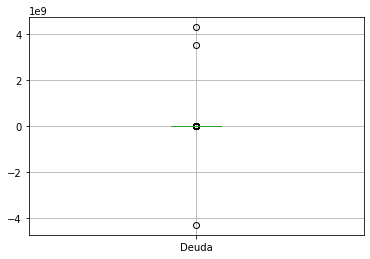

In [466]:
fig = dStud.boxplot(column="Deuda")

#### Cuales son los valores atipicos

In [467]:
display(dStud[(dStud["Deuda"]>1e9) | (dStud["Deuda"]<0)].tail(),dStud.shape)

,ID,PudoPagar,Estudiante,Deuda,Cuenta
2496,2497,0,Si,-1359419,1532055
2497,2498,0,No,-3709522,5110508
2498,2499,0,No,-2495053,4239920
2499,2500,0,No,4299357653,7981139
2598,2599,0,No,3533318222,2532130


(10002, 5)

### Noveno Problema (Valor atipico de Cuenta)

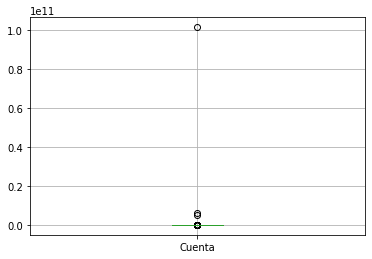

In [468]:
fig = dStud.boxplot(column="Cuenta")

## Corrección de problemas de datos

### Corrección del primer problema

Se identifico que la columna categórica binaria "PudoPagar" es tipo int64. Para corregir el problema, se procedió a realizar la conversión de int64 a object.   

In [469]:
dStud["PudoPagar"] = dStud["PudoPagar"].astype(object)
dStud["PudoPagar"].dtypes

dtype('O')

### Corrección del segundo problema

La columna "Estudiante" es una variable categórica binaria, en esta feature se encontró cinco diferentes valores: 1, 0, "Yes", "No" y nan. Para solucionar lo anterior, se buscara los valores '1' y '0'. Después se remplazara con las valores "Si" y "No" respectivamente. Con respecto a los nan, se solucionara posteriormente.


In [470]:
dStud['Estudiante'].replace({"1":"Si","0":"No"}, inplace=True)

In [471]:
mask = ((dStud['Estudiante'] == '1') | (dStud['Estudiante'] == '0'))
dStud[mask]

,ID,PudoPagar,Estudiante,Deuda,Cuenta


### Corrección del tercer problema

Se encontró que hay cuatro registros con valores nulos en el feature "Estudiante". Para solucionar este problema se procedió a eliminarlos, ya que, estos representan tan solo el 0.039% de todo la tabla.

In [472]:
dStud.dropna(axis=0,inplace=True)
dStud.notnull().apply(pd.Series.value_counts)

,ID,PudoPagar,Estudiante,Deuda,Cuenta
True,9998,9998,9998,9998,9998


### Corrección del cuarto problema

Se encontró en el dataset dos registros duplicados. Para solucionar el problema se procedió a eliminarlos, ya que son el 0.019% del dataset sin modificaciones, sumado al porcentaje de registros eliminados seria 0.0599%.

In [473]:
dStud.drop_duplicates(inplace=True)
display(dStud[dStud.duplicated(keep=False)],
dStud.shape)

,ID,PudoPagar,Estudiante,Deuda,Cuenta


(9996, 5)

### Corrección del quinto problema

Se identifico dos valores negativos(anormales) en el feature "ID", se procedio a eliminar los registros, ya que, estos suman tan solo el 0.019%, que sumado con el porcentaje anterior seria aproximadamente un 0.0.0799%.

In [474]:
dStud = dStud[dStud["ID"]>=0]
display(dStud[dStud["ID"]<0],dStud.shape)

,ID,PudoPagar,Estudiante,Deuda,Cuenta


(9994, 5)

### Corrección del sexto problema

Se identifico 999 valores negativos en el feature "Deuda". Para solucionar lo anterior, se procedió a eliminarlos, ya que tan solo suman el 9.988%, que sumandolo con el porcentaje global de datos eliminados seria, de 10.06%.

In [475]:
dStud = dStud[dStud["Deuda"]>=0]
display(dStud[dStud["Deuda"]<0],dStud.shape)

,ID,PudoPagar,Estudiante,Deuda,Cuenta


(8995, 5)

### Corrección del septimo problema

Se identifico 1 valor negativo en el feature "Cuenta". Para solucionar lo anterior, se procedió a eliminarlo. El porcentaje global de los datos eliminados es 10.07%.

In [476]:
dStud = dStud[dStud["Cuenta"]>=0]
display(dStud[dStud["Cuenta"]<0],dStud.shape)

,ID,PudoPagar,Estudiante,Deuda,Cuenta


(8994, 5)

### Corrección del octavo problema

Se identifico n valores atipicos en el feature "Deuda". Para solucionar este problema se procedio a eliminar dichos registros

In [477]:
dStud = dStud[(dStud["Deuda"]<1e9)]

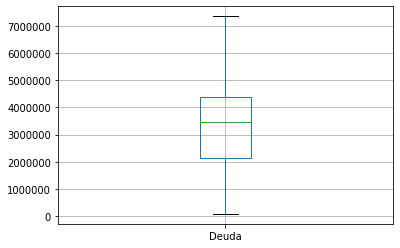

In [478]:
fig = dStud.boxplot(column="Deuda")

In [479]:
dStud.shape

(8992, 5)

### Corrección del noveno problema

Se identifico n valores atipicos en el feature "Cuenta". Para solucionar este problema se procedio a eliminar dichos registros.

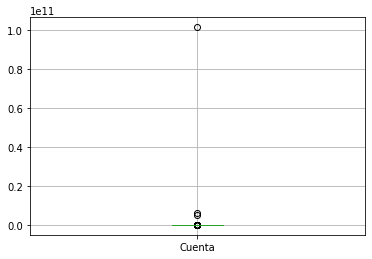

In [482]:
fig = dStud.boxplot(column="Cuenta")

In [483]:
dStud = dStud[dStud["Cuenta"]<0.2e11]

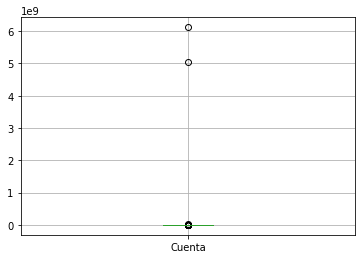

In [484]:
fig = dStud.boxplot(column="Cuenta")

In [485]:
dStud = dStud[dStud["Cuenta"]<1e9]

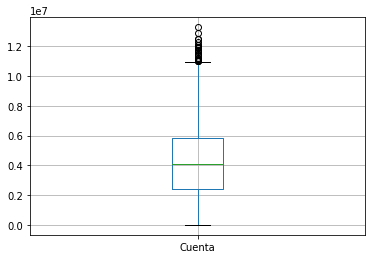

In [486]:
fig = dStud.boxplot(column="Cuenta")

dStud = dStud[dStud["Cuenta"].between(dStud["Cuenta"].quantile(0),dStud["Cuenta"].quantile(0.9))]
dStud.shape

In [487]:
dStud.shape

(8989, 5)

# 2. Modelo de referencia (Baseline)

In [488]:
noPudoPagar = (dStud['PudoPagar']==0)
baseline = dStud[noPudoPagar]
display(baseline.shape[0]/dStud.shape[0])

0.9674046056291022

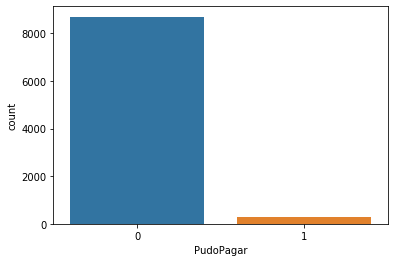

In [489]:
baselineGrafico = sns.countplot(x="PudoPagar", data=dStud)

In [490]:
dStudNumeric = (dStud.dtypes == 'int64')
dStudNumeric = [n for n in dStudNumeric.index if dStudNumeric[n]]
dStudNumeric = dStud[dStudNumeric]
dStudNumeric.head()

,ID,Deuda,Cuenta
0,1,4436163,3647632
1,2,1210613,4085902
2,3,3176714,5367746
3,4,3570449,2646253
4,5,3846350,3928279


In [492]:
dStudText = (dStud.dtypes == 'object')
dStudText = [n for n in dStudText.index if dStudText[n]]
dStudText = dStud[dStudText]
dStudText.head()

,PudoPagar,Estudiante
0,0,No
1,0,Si
2,0,No
3,0,No
4,0,No


In [493]:
x = dStudNumeric
y = dStudText["PudoPagar"]

In [ ]:
mf = metrics.confusion_matrix()

# 3. Holdout sobre el dataset

In [ ]:
y = dStud['PudoPagar']
x = dStudNumeric

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=87654, stratify=y)

In [ ]:
norm = Normalizer()
norm.fit(X_train)

In [ ]:
X_train.describe()

In [ ]:
X_train.head()

In [ ]:
norm.transform(X_train)

In [ ]:
display(dStudNumeric['Deuda'].max(), dStudNumeric['Deuda'].min())

...

...

# 4. KNN

# 5. Naive Bayes

...

...

...

# 6. Comparación y conclusiones

...

...

...